### 회귀 실습: 자전거 대여(공유)수요 예측

* date : hourly date + timestamp
* season : 1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울
* holiday : 1 = 토, 일요일의 주말을 제외한 국경일 등의 휴일, 0 = 휴일이 아닌날
* workingday : 1 = 토, 일요일의 주말 및 휴일이 아닌 주중, 0 = 주말 및 휴일
* weather : 1=맑음, 약간 구름 낀 흐림, 2=안개, 안개 + 흐림, 3=가벼운 눈, 가벼운 비 + 천둥, 4=심한 눈/비, 천둥/번개
* temp:온도(섭씨)
* atemp:체감온도(섭씨)
* humidity:상대습도
* windspeed:풍속
* casual:사전에 등록되지 않는 사용자가 대여한 횟수
* registered:사전에 등록된 사용자가 대여한 횟수
* count:대여 횟수

### 실습 순서
1. csv 파일 읽어오기
2. info, desc
3. datetime 필드 -> 년, 월, 일, 시간
4. casual, registered 제거
5. x의 피처별 count의 관계를 막대그래프로 시각화
6. 데이터 분리
7. 모델 설정 : LinearRegression()
8. 훈련, predict,
9. matric 보기(rmse, rmsle)
* 주요 infortance값 시각화(coef_)
-------------------------------------------------------------
10. feature들을 one-hot encoding
11. RandomForestRegressor, GradientBoostingRegressor XGBRegressor,LGBMRegressor 알고리즘 적용

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

file_path = r"C:\Users\virtue\Desktop\머신러닝\bike_train.csv"
df = pd.read_csv(file_path)

### 2. info, desc

In [38]:
# 데이터프레임 기본 정보
print(df.info)
print('\n')

# 데이터프레임 기술 통계 정보 요약
print(df.describe())

<bound method DataFrame.info of                   datetime  season  holiday  workingday  weather   temp  \
0      2011-01-01 00:00:00       1        0           0        1   9.84   
1      2011-01-01 01:00:00       1        0           0        1   9.02   
2      2011-01-01 02:00:00       1        0           0        1   9.02   
3      2011-01-01 03:00:00       1        0           0        1   9.84   
4      2011-01-01 04:00:00       1        0           0        1   9.84   
...                    ...     ...      ...         ...      ...    ...   
10881  2012-12-19 19:00:00       4        0           1        1  15.58   
10882  2012-12-19 20:00:00       4        0           1        1  14.76   
10883  2012-12-19 21:00:00       4        0           1        1  13.94   
10884  2012-12-19 22:00:00       4        0           1        1  13.94   
10885  2012-12-19 23:00:00       4        0           1        1  13.12   

        atemp  humidity  windspeed  casual  registered  count  
0  

### 3. datetime 필드 -> 년, 월, 일, 시간

In [39]:
df['datetime']

0        2011-01-01 00:00:00
1        2011-01-01 01:00:00
2        2011-01-01 02:00:00
3        2011-01-01 03:00:00
4        2011-01-01 04:00:00
                ...         
10881    2012-12-19 19:00:00
10882    2012-12-19 20:00:00
10883    2012-12-19 21:00:00
10884    2012-12-19 22:00:00
10885    2012-12-19 23:00:00
Name: datetime, Length: 10886, dtype: object

In [40]:
# lambda 년,월,일 시간 따로 쪼개기
df['datetime'].apply(lambda x: x.split(' '))

0        [2011-01-01, 00:00:00]
1        [2011-01-01, 01:00:00]
2        [2011-01-01, 02:00:00]
3        [2011-01-01, 03:00:00]
4        [2011-01-01, 04:00:00]
                  ...          
10881    [2012-12-19, 19:00:00]
10882    [2012-12-19, 20:00:00]
10883    [2012-12-19, 21:00:00]
10884    [2012-12-19, 22:00:00]
10885    [2012-12-19, 23:00:00]
Name: datetime, Length: 10886, dtype: object

In [41]:
df['datetime'].apply(lambda x: x.split(' ')[1])

0        00:00:00
1        01:00:00
2        02:00:00
3        03:00:00
4        04:00:00
           ...   
10881    19:00:00
10882    20:00:00
10883    21:00:00
10884    22:00:00
10885    23:00:00
Name: datetime, Length: 10886, dtype: object

In [42]:
# 열이름 지정
df['year'] = df['datetime'].apply(lambda x: x.split('-')[0])
df['month'] = df['datetime'].apply(lambda x: x.split('-')[1])
df['day'] = df['datetime'].apply(lambda x: x.split('-')[2])
df['time'] = df['datetime'].apply(lambda x: x.split(' ')[1])

## 4. casual, registered 제거(예측 쉬운 y값 제거)

In [43]:
df.drop(['casual', 'registered'],axis = 1, inplace = True)


In [44]:
df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,time
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,16,2011,01,01 00:00:00,00:00:00
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,40,2011,01,01 01:00:00,01:00:00
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,32,2011,01,01 02:00:00,02:00:00
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,13,2011,01,01 03:00:00,03:00:00
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,2011,01,01 04:00:00,04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,336,2012,12,19 19:00:00,19:00:00
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,241,2012,12,19 20:00:00,20:00:00
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,168,2012,12,19 21:00:00,21:00:00
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,129,2012,12,19 22:00:00,22:00:00


### 5. x의 피처별 count의 관계를 막대그래프로 시각화

[Text(0.5, 0, 'time'), Text(0.5, 1.0, 'Time')]

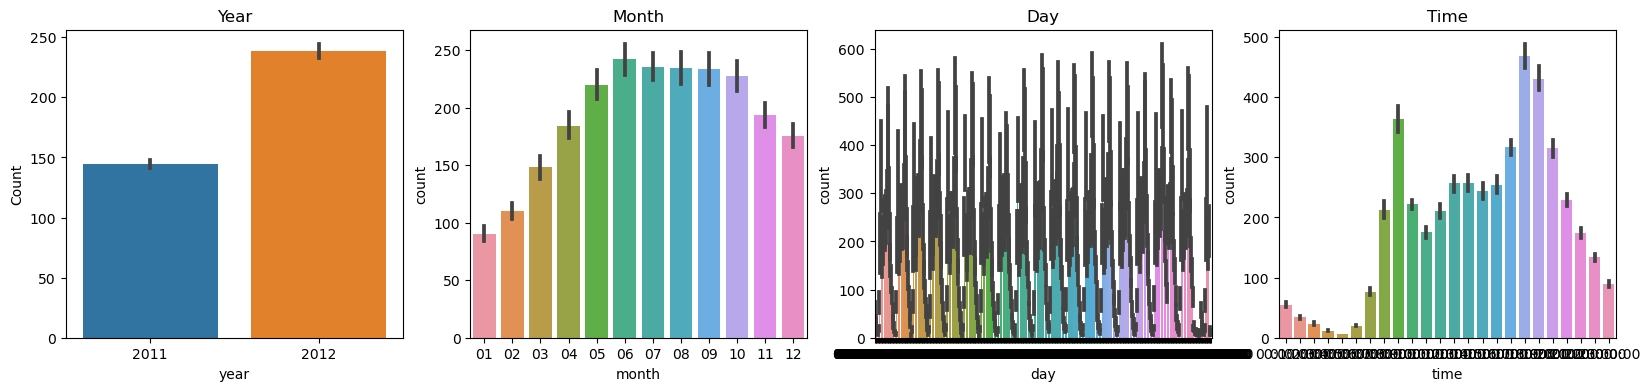

In [56]:
# sunplot 막대 그래프 

figure, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4)

figure.set_size_inches(20,4)

sns.barplot(data=df, x="year", y="count", ax=ax1)
sns.barplot(data=df, x="month", y="count", ax=ax2)
sns.barplot(data=df, x="day", y="count", ax=ax3)
sns.barplot(data=df, x="time", y="count", ax=ax4)

ax1.set(ylabel='Count', title="Year")
ax2.set(xlabel='month', title="Month")
ax3.set(xlabel='day', title="Day")
ax4.set(xlabel='time', title="Time") 

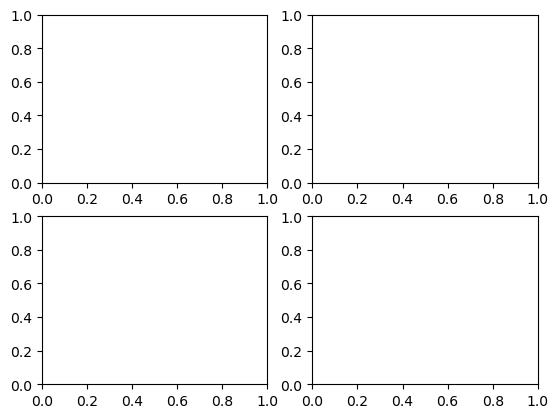

In [47]:
# boxplot 시각화 2행 2열

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)

fig.set_size_inches(12, 10)
sns.boxplot(data=df, y="count",orient="v", ax=ax2)
sns.boxplot(dat)


### 6. 데이터 분리